# Final figures for PIK3CA story

### Standard Imports

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import json
import operator

#import the Endometrial data from CPTAC package
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. This import contains
information about the package. In order to access a specific data set,
import a CPTAC subfolder by either 'import CPTAC.DataName' or 'from
CPTAC import DataName'.
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Get proteomics data from CPTAC

In [3]:
proteomics = CPTAC.get_proteomics()

### Make Proteomics BoxPlot for AKT1, AKT2, PTEN, PIK3CA

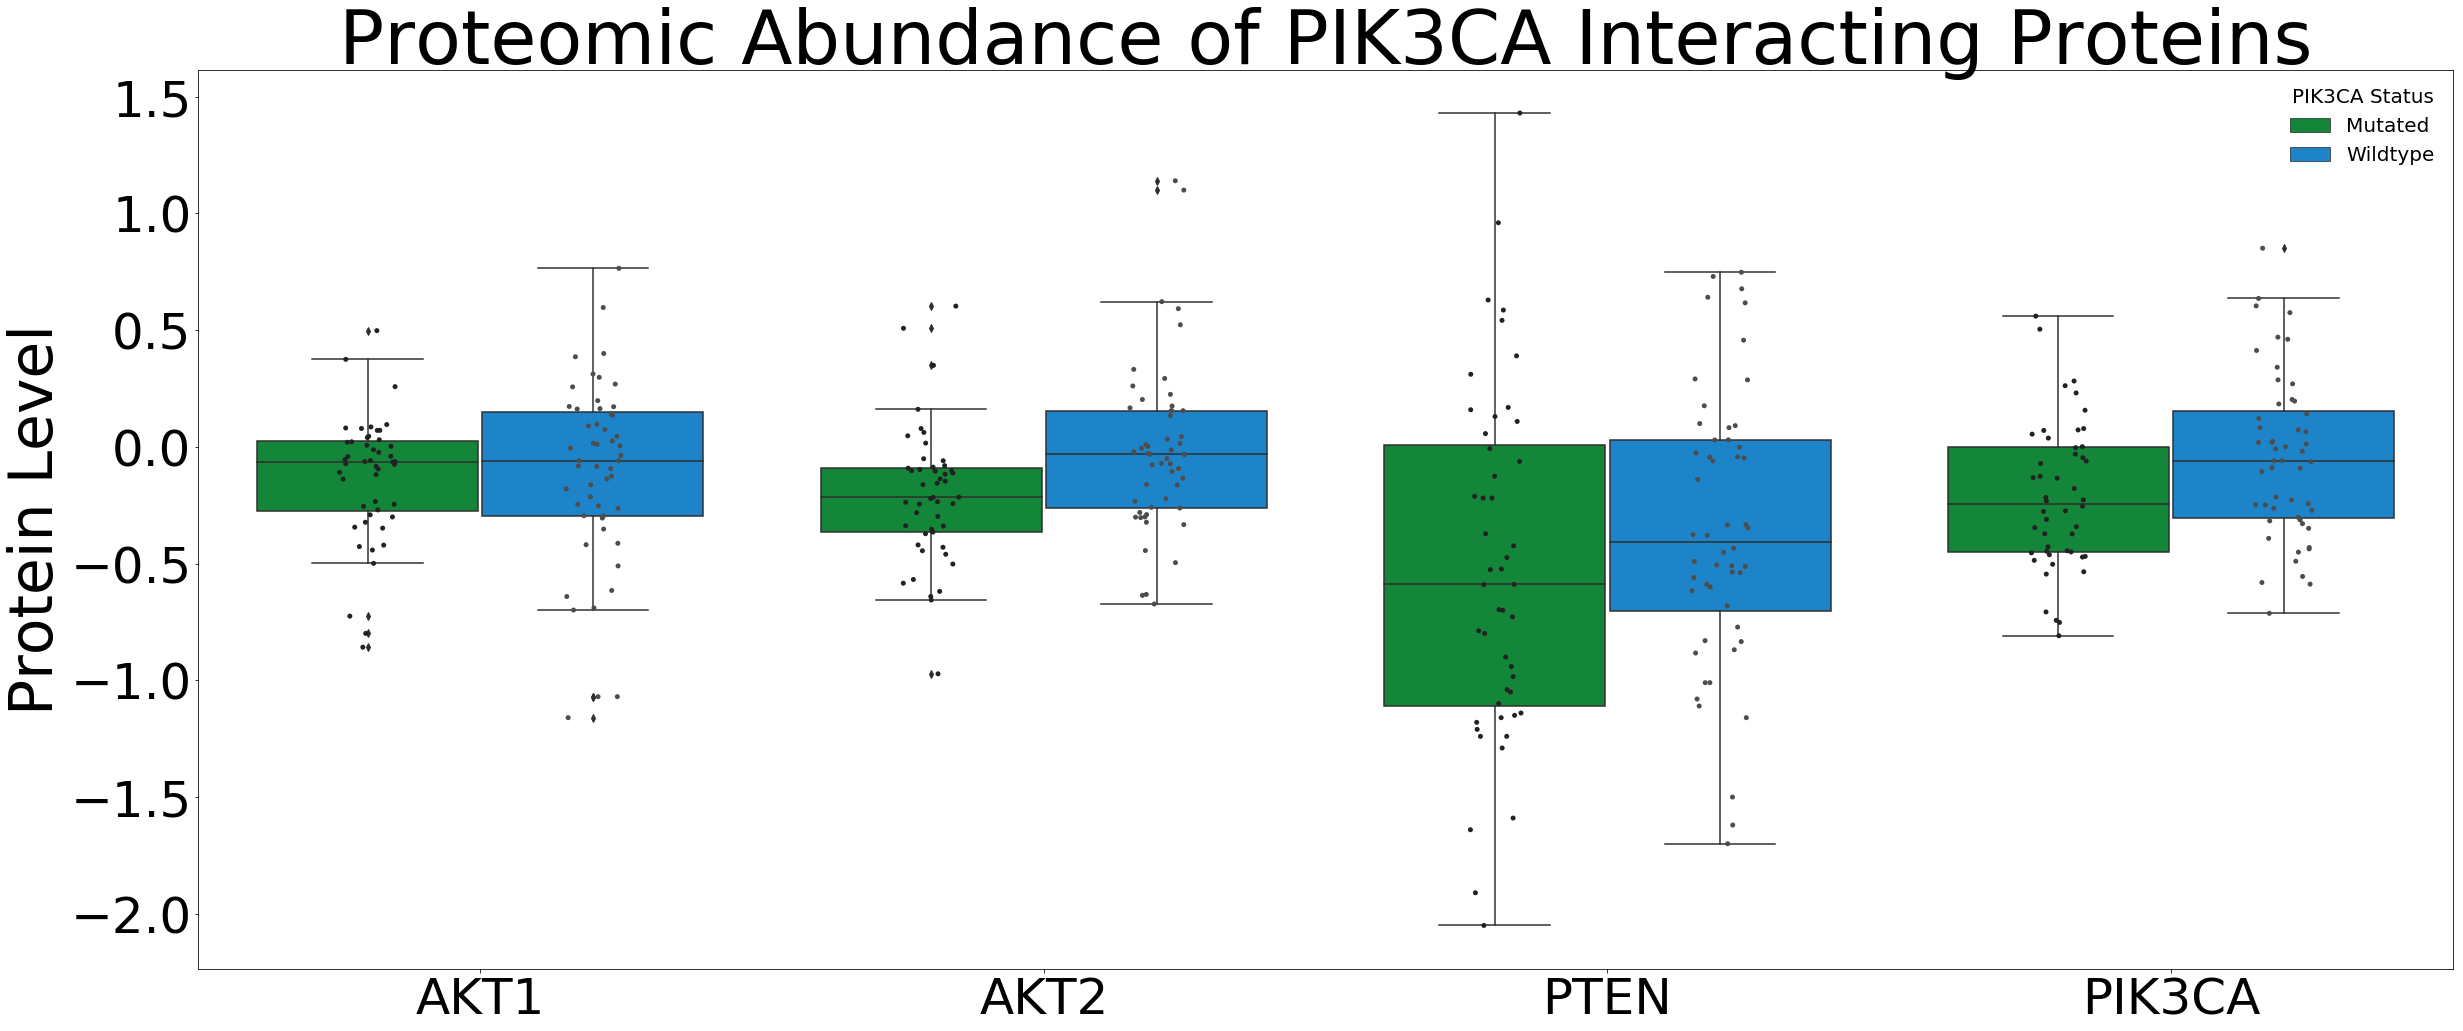

In [25]:
gene = 'PIK3CA'
protList = ['AKT1','AKT2','PTEN','PIK3CA']

'''Get the PIK3CA mutation dataframe'''
plotdf = CPTAC.compare_mutations(proteomics, gene)

'''Look only at Tumor patients'''
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

'''Add in the protein levels for every protein in the list'''
for protein in protList:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)
    proteindf = proteindf.loc[proteindf['Patient_Type'] == 'Tumor']
    proteindf = proteindf[[protein]]
    #print("PROTDF:")
    #print(proteindf)
    plotdf = plotdf.join(proteindf)

#print(plotdf)

plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation',
                                      'In_Frame_Del': 'Mutation'
                                     }})

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Signal')
plotdf = plotdf.dropna(axis=0)

a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutation": "#009933", "Wildtype": "#008ae6"}

#print(plotdf)

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Signal', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Signal', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Level', fontsize='60')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Proteomic Abundance of PIK3CA Interacting Proteins', fontsize = '75')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Wildtype'], title='PIK3CA Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()